# Child Mind Institute - Detect Sleep States
## Feature Engineering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.signal import find_peaks

In [2]:
df = pd.read_csv('cmi_data/filtered_train_series.csv')

In [3]:
def add_features(df):
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

    # Time-Based Features
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['minute_of_hour'] = df['timestamp'].dt.minute
    df['second_of_minute'] = df['timestamp'].dt.second
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day_of_month'] = df['timestamp'].dt.day
    df['month_of_year'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year

    # Drop the timestamp column
    df = df.drop(columns=['timestamp'])
    
    # Time of Day Features
    df['time_of_day_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['time_of_day_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
    
    # Aggregate statistics for `anglez`
    df['series_anglez_mean'] = df.groupby('series_id')['anglez'].transform('mean')
    df['series_anglez_median'] = df.groupby('series_id')['anglez'].transform('median')
    df['series_anglez_std'] = df.groupby('series_id')['anglez'].transform('std')
    df['series_anglez_count'] = df.groupby('series_id')['anglez'].transform('count')
    df['series_anglez_max'] = df.groupby('series_id')['anglez'].transform('max')
    df['series_anglez_min'] = df.groupby('series_id')['anglez'].transform('min')
    df['series_anglez_sum'] = df.groupby('series_id')['anglez'].transform('sum')

    # Aggregate statistics for `enmo`
    df['series_enmo_mean'] = df.groupby('series_id')['enmo'].transform('mean')
    df['series_enmo_median'] = df.groupby('series_id')['enmo'].transform('median')
    df['series_enmo_std'] = df.groupby('series_id')['enmo'].transform('std')
    df['series_enmo_count'] = df.groupby('series_id')['enmo'].transform('count')
    df['series_enmo_max'] = df.groupby('series_id')['enmo'].transform('max')
    df['series_enmo_min'] = df.groupby('series_id')['enmo'].transform('min')
    df['series_enmo_sum'] = df.groupby('series_id')['enmo'].transform('sum')

    # Value counts and threshold-based features
    # Counts values in `anglez` greater than certain thresholds
    df['series_anglez_vc_greater_1'] = df.groupby('series_id')['anglez'].transform(lambda x: (x > 1).sum())
    df['series_anglez_vc_greater_0'] = df.groupby('series_id')['anglez'].transform(lambda x: (x > 0).sum())
    df['series_enmo_vc_greater_1'] = df.groupby('series_id')['enmo'].transform(lambda x: (x > 1).sum())
    df['series_enmo_vc_greater_0'] = df.groupby('series_id')['enmo'].transform(lambda x: (x > 0).sum())

    # Cumulative features within each series
    df['cumulative_anglez'] = df.groupby('series_id')['anglez'].cumsum()
    df['cumulative_enmo'] = df.groupby('series_id')['enmo'].cumsum()
    df['cumulative_max_anglez'] = df.groupby('series_id')['anglez'].cummax()
    df['cumulative_max_enmo'] = df.groupby('series_id')['enmo'].cummax()

    # Rolling window statistics (e.g., rolling mean/std over a window of 10)
    window = 10
    df['anglez_rolling_mean'] = df.groupby('series_id')['anglez'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    df['anglez_rolling_std'] = df.groupby('series_id')['anglez'].transform(lambda x: x.rolling(window=window, min_periods=1).std())
    df['enmo_rolling_mean'] = df.groupby('series_id')['enmo'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    df['enmo_rolling_std'] = df.groupby('series_id')['enmo'].transform(lambda x: x.rolling(window=window, min_periods=1).std())

    # Interaction features between `anglez` and `enmo`
    df['anglez_enmo_product'] = df['anglez'] * df['enmo']
    df['anglez_enmo_ratio'] = df['anglez'] / (df['enmo'] + 1e-6)  # Adding epsilon to avoid division by zero

    # Skew and Kurtosis over rolling window
    df['anglez_skew'] = df.groupby('series_id')['anglez'].transform(lambda x: x.rolling(window=window, min_periods=1).skew())
    df['enmo_kurtosis'] = df.groupby('series_id')['enmo'].transform(lambda x: x.rolling(window=window, min_periods=1).kurt())

    # Absolute differences (change points) for detecting abrupt changes
    df['anglez_change_point'] = df.groupby('series_id')['anglez'].diff().abs()
    df['enmo_change_point'] = df.groupby('series_id')['enmo'].diff().abs()

    # Value counts for distinct `anglez` and `enmo` states
    df['series_anglez_unique_count'] = df.groupby('series_id')['anglez'].transform('nunique')
    df['series_enmo_unique_count'] = df.groupby('series_id')['enmo'].transform('nunique')

    # Normalized Interaction Terms
    df['normalized_anglez'] = (df['anglez'] - df['series_anglez_mean']) / (df['series_anglez_std'] + 1e-6)
    df['normalized_enmo'] = (df['enmo'] - df['series_enmo_mean']) / (df['series_enmo_std'] + 1e-6)
    df['normalized_anglez_enmo_product'] = df['normalized_anglez'] * df['normalized_enmo']

    # Higher-Order Polynomial Features
    df['anglez_squared'] = df['anglez'] ** 2
    df['enmo_squared'] = df['enmo'] ** 2
    df['anglez_enmo_product_squared'] = (df['anglez'] * df['enmo']) ** 2
    df['anglez_cubed'] = df['anglez'] ** 3
    df['enmo_cubed'] = df['enmo'] ** 3

    # Additional Interaction Terms with Other Variables
    df['anglez_hour_interaction'] = df['anglez'] * df['hour_of_day']
    df['enmo_cumulative_enmo'] = df['enmo'] * df['cumulative_enmo']
    df['anglez_enmo_day_interaction'] = df['anglez'] * df['enmo'] * df['day_of_week']

    # Drop timebased features
    df = df.drop(columns=['hour_of_day', 'minute_of_hour', 'second_of_minute', 'day_of_week', 'day_of_month', 'month_of_year', 'year'])

    return df

In [4]:
df = add_features(df)
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df.describe()

,step,anglez,enmo,event,time_of_day_sin,time_of_day_cos,series_anglez_mean,series_anglez_median,series_anglez_std,series_anglez_count,...,normalized_enmo,normalized_anglez_enmo_product,anglez_squared,enmo_squared,anglez_enmo_product_squared,anglez_cubed,enmo_cubed,anglez_hour_interaction,enmo_cumulative_enmo,anglez_enmo_day_interaction
count,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,...,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06,1.052169e+06
mean,2.631570e+05,-8.989119e+00,4.059736e-02,1.366606e-02,2.332570e-02,-1.460729e-03,-9.003176e+00,-9.741563e+00,3.480572e+01,4.499081e+03,...,-9.766340e-05,2.659258e-02,1.431092e+03,1.234760e-02,7.178471e+00,-2.471339e+04,1.428491e-02,-9.471633e+01,4.056338e+00,-7.639576e-01
std,1.856734e+05,3.674628e+01,1.034382e-01,1.503061e-01,7.070988e-01,7.067291e-01,1.029007e+01,1.180614e+01,5.850852e+00,1.789183e+03,...,9.999366e-01,8.240352e-01,1.780972e+03,1.726311e-01,2.070700e+02,1.574367e+05,5.357766e-01,4.440221e+02,1.412679e+01,9.548167e+00
min,5.400000e+01,-9.000000e+01,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-3.299563e+01,-3.639995e+01,1.800689e+01,2.450000e+02,...,-1.109688e+00,-5.934975e+01,0.000000e+00,0.000000e+00,0.000000e+00,-7.290000e+05,0.000000e+00,-2.070000e+03,0.000000e+00,-5.553395e+02
25%,1.164890e+05,-3.426310e+01,6.000000e-04,0.000000e+00,-7.071068e-01,-7.071068e-01,-1.588418e+01,-1.740210e+01,3.236785e+01,3.473000e+03,...,-3.874744e-01,-1.793618e-01,1.236500e+02,3.600000e-07,5.384448e-05,-4.022351e+04,2.160000e-10,-3.132333e+02,2.402059e-02,-1.202923e+00
50%,2.438830e+05,-1.006120e+01,1.580000e-02,0.000000e+00,1.224647e-16,6.123234e-17,-9.360710e+00,-1.082935e+01,3.618686e+01,4.067000e+03,...,-2.580533e-01,7.062445e-03,6.417052e+02,2.496400e-04,5.782774e-02,-1.018473e+03,3.944312e-06,-6.187320e+01,7.813811e-01,0.000000e+00
75%,3.680390e+05,1.281500e+01,4.180000e-02,0.000000e+00,7.071068e-01,7.071068e-01,-3.742666e+00,-3.358800e+00,3.861737e+01,5.416000e+03,...,4.965751e-02,2.116354e-01,2.146423e+03,1.747240e-03,8.358871e-01,2.104533e+03,7.303463e-05,1.003428e+02,3.303698e+00,0.000000e+00
max,1.433866e+06,9.000000e+01,5.430300e+00,2.000000e+00,1.000000e+00,1.000000e+00,2.607866e+01,3.114795e+01,4.547482e+01,1.436200e+04,...,5.787939e+01,9.231780e+01,8.100000e+03,2.948816e+01,1.263324e+05,7.290000e+05,1.601295e+02,2.059779e+03,1.386845e+03,1.065760e+03


In [5]:
def plot_pca(df):

    # Select features
    X = df.drop(columns=['event', 'series_id'])
    feature_names = X.columns

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_ * 100

    # Get loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    # Create a DataFrame for the loadings
    loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'])
    loadings_df['Variable'] = feature_names

    # Create a DataFrame for observations
    scores_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    scores_df['event'] = df['event'].values

    # Separate data based on 'event' values
    event_1 = scores_df[scores_df['event'] == 1]
    event_2 = scores_df[scores_df['event'] == 2]
    other_events = scores_df[~scores_df['event'].isin([1, 2])]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))

    ### Subplot 1: Observations ###
    axes[0].set_title('PCA - train - Observations', fontsize=16)
    axes[0].scatter(other_events['PC1'], other_events['PC2'], 
                    alpha=0.6, s=50, c='grey', label='no_event')
    axes[0].scatter(event_2['PC1'], event_2['PC2'], 
                    alpha=0.7, s=100, c='blue', marker='D', label='wakeup')
    axes[0].scatter(event_1['PC1'], event_1['PC2'], 
                    alpha=0.7, s=100, c='red', marker='X', label='onset')
    axes[0].set_xlabel(f'PC1 ({explained_variance[0]:.2f}%)', fontsize=12)
    axes[0].set_ylabel(f'PC2 ({explained_variance[1]:.2f}%)', fontsize=12)
    axes[0].legend()
    axes[0].grid()

    ### Subplot 2: Variables ###
    axes[1].set_title('PCA - train - Variables', fontsize=16)
    for i in range(loadings_df.shape[0]):
        axes[1].arrow(0, 0, loadings_df.loc[i, 'PC1'], 
                    loadings_df.loc[i, 'PC2'],
                    color='grey', alpha=0.5, head_width=0.02, head_length=0.02)
        axes[1].text(loadings_df.loc[i, 'PC1']*1.15, 
                    loadings_df.loc[i, 'PC2']*1.15,
                    loadings_df.loc[i, 'Variable'], 
                    color='black', ha='center', va='center', fontsize=12)

    axes[1].set_xlabel('PC1', fontsize=12)
    axes[1].set_ylabel('PC2', fontsize=12)
    axes[1].grid()
    axes[1].set_ylim(-0.7, 0.8)
    axes[1].set_xlim(-0.5, 0.9)

    plt.tight_layout()
    plt.show()

/home/etudiant/.conda/envs/sleep-states/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


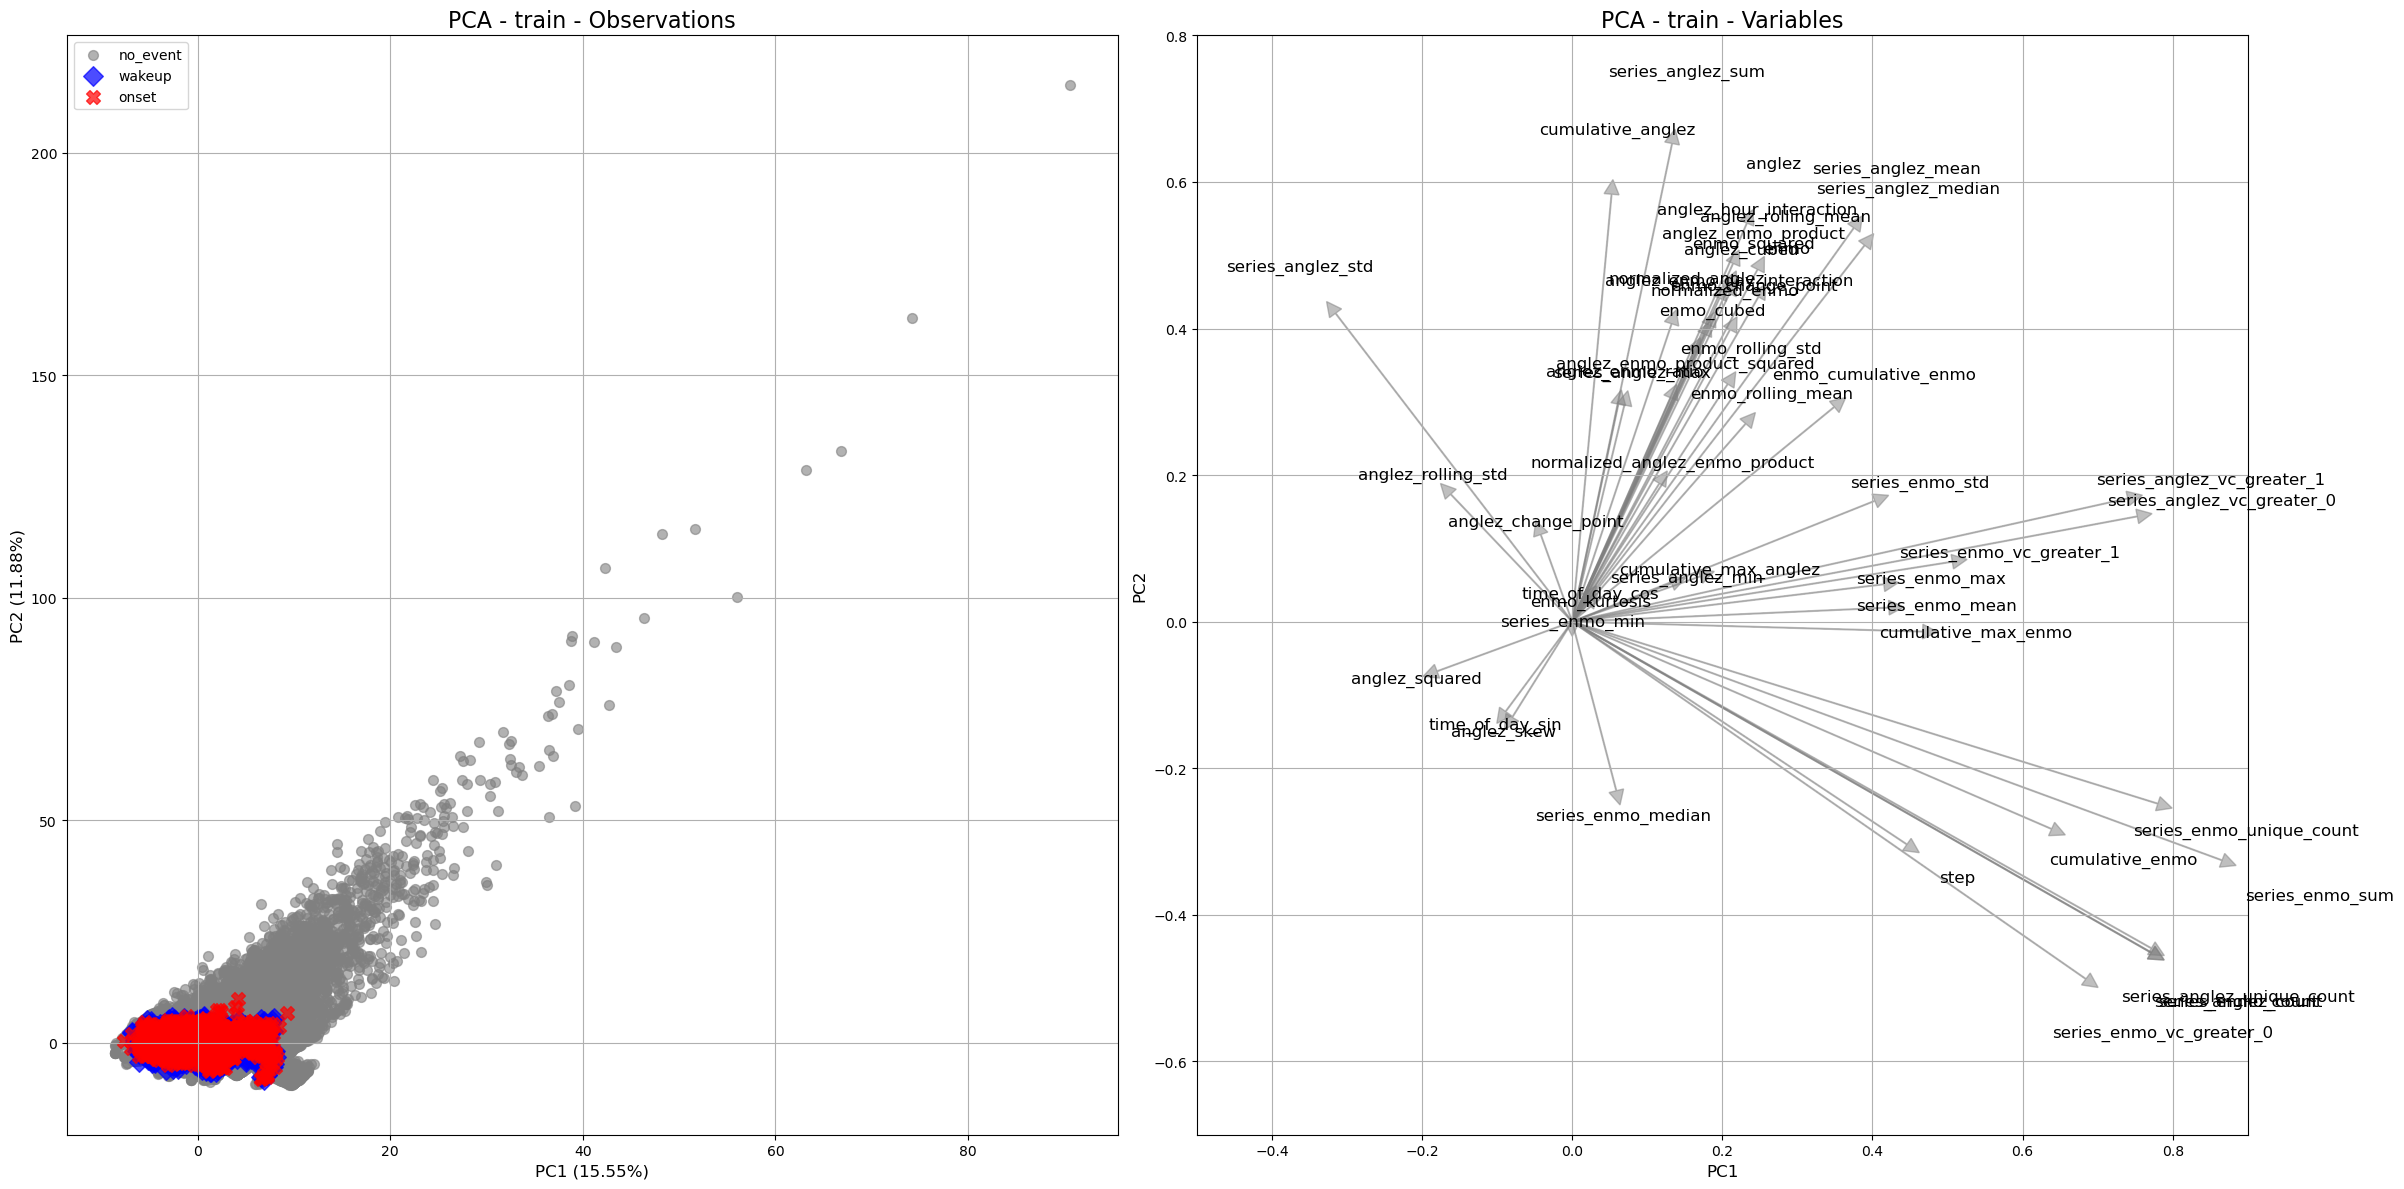

In [6]:
%matplotlib inline

plot_pca(df)

In [7]:
df.to_csv('data/features_train_series.csv', index=False)

OSError: Cannot save file into a non-existent directory: 'data'

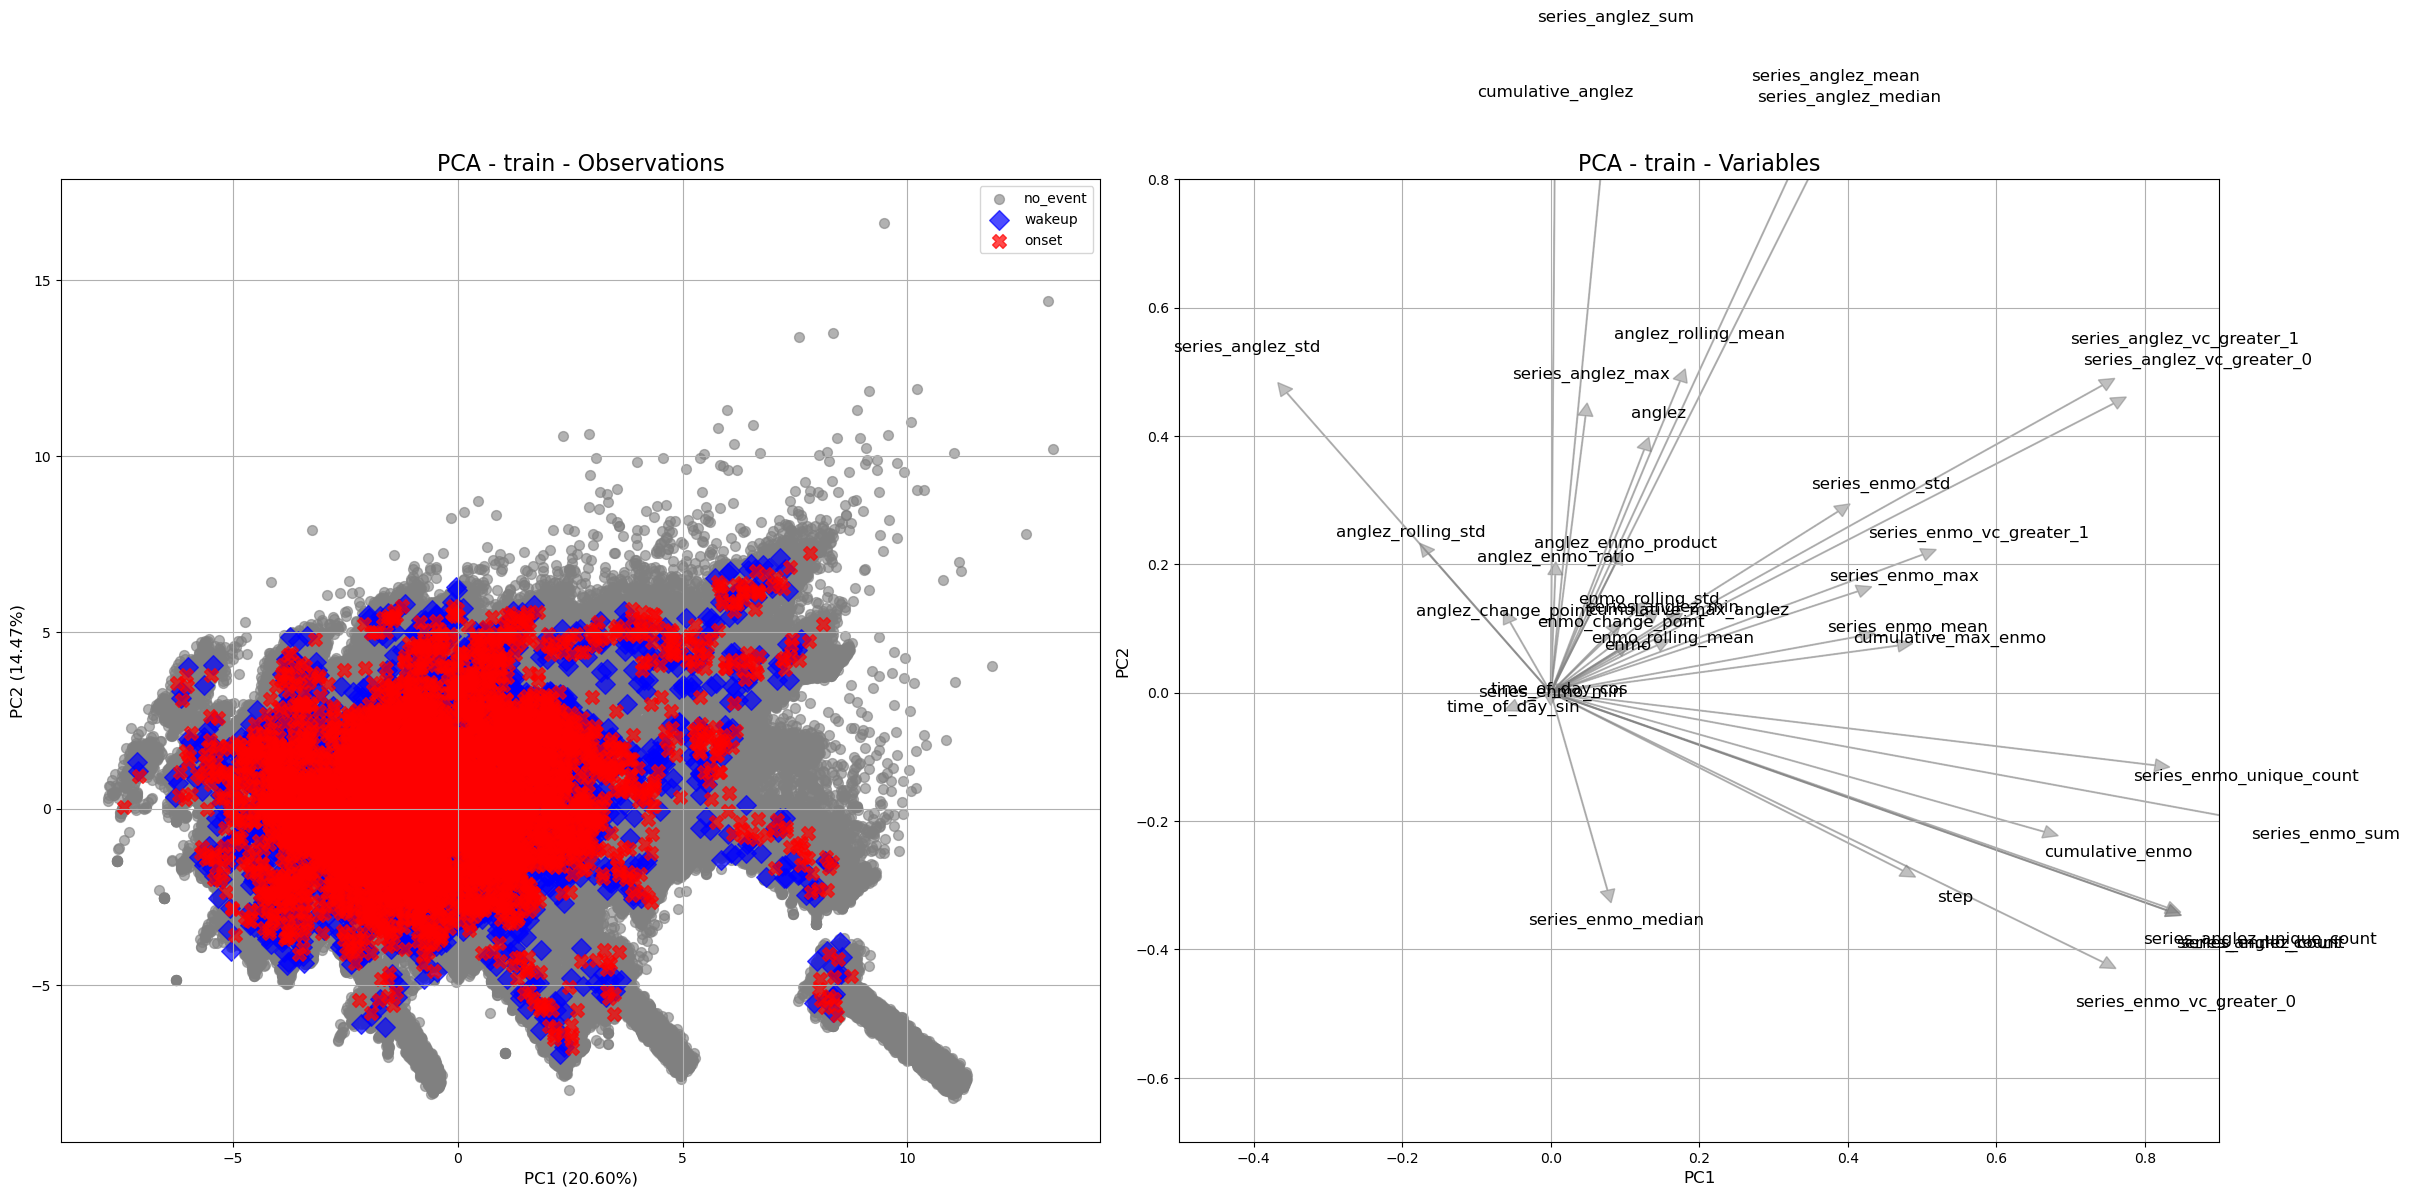

In [9]:
import numpy as np
from scipy.fft import fft
from scipy.stats import entropy

dt = pd.read_csv('cmi_data/filtered_train_series.csv')

def features(df):

    # # Convert timestamp to datetime
    # df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

    # # --- Time-Based Cyclical Features ---
    # df['time_of_day_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.hour / 24)
    # df['time_of_day_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.hour / 24)

    # # --- Core Motion Statistics (mean, median, std, max, min) ---
    # # Aggregate statistics by `series_id` for `anglez` and `enmo`
    # for col in ['anglez', 'enmo']:
    #     df[f'series_{col}_mean'] = df.groupby('series_id')[col].transform('mean')
    #     df[f'series_{col}_median'] = df.groupby('series_id')[col].transform('median')
    #     df[f'series_{col}_std'] = df.groupby('series_id')[col].transform('std')
    #     df[f'series_{col}_max'] = df.groupby('series_id')[col].transform('max')
    #     df[f'series_{col}_min'] = df.groupby('series_id')[col].transform('min')

    # # --- Threshold-Based Counts for anglez and enmo ---
    # for col in ['anglez', 'enmo']:
    #     df[f'{col}_count_greater_0'] = df.groupby('series_id')[col].transform(lambda x: (x > 0).sum())
    #     df[f'{col}_count_greater_1'] = df.groupby('series_id')[col].transform(lambda x: (x > 1).sum())
    #     df[f'{col}_count_greater_20'] = df.groupby('series_id')[col].transform(lambda x: (x > 2).sum())

    # # --- Rolling Window Features (mean and std for longer windows) ---
    # window_sizes = [10, 30, 60]
    # for window in window_sizes:
    #     df[f'anglez_rolling_mean_{window}'] = df.groupby('series_id')['anglez'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    #     df[f'anglez_rolling_std_{window}'] = df.groupby('series_id')['anglez'].transform(lambda x: x.rolling(window=window, min_periods=1).std())
    #     df[f'enmo_rolling_mean_{window}'] = df.groupby('series_id')['enmo'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    #     df[f'enmo_rolling_std_{window}'] = df.groupby('series_id')['enmo'].transform(lambda x: x.rolling(window=window, min_periods=1).std())

    # # --- Change Points (absolute differences) ---
    # df['anglez_change_point'] = df.groupby('series_id')['anglez'].diff().abs()
    # df['enmo_change_point'] = df.groupby('series_id')['enmo'].diff().abs()

    # # --- Lagged Features ---
    # df['anglez_lag1'] = df.groupby('series_id')['anglez'].shift(1)
    # df['enmo_lag1'] = df.groupby('series_id')['enmo'].shift(1)
    # df['anglez_lag2'] = df.groupby('series_id')['anglez'].shift(2)
    # df['enmo_lag2'] = df.groupby('series_id')['enmo'].shift(2)

    # # --- Entropy and Variance ---
    # # Calculate entropy over each series
    # df['anglez_entropy'] = df.groupby('series_id')['anglez'].transform(lambda x: entropy(np.histogram(x, bins=10)[0]))
    # df['enmo_entropy'] = df.groupby('series_id')['enmo'].transform(lambda x: entropy(np.histogram(x, bins=10)[0]))

    # # Calculate variance
    # df['anglez_variance'] = df.groupby('series_id')['anglez'].transform('var')
    # df['enmo_variance'] = df.groupby('series_id')['enmo'].transform('var')

    # # --- Cumulative Inactivity Duration ---
    # # Define inactivity as `enmo` below a threshold (e.g., 1)
    # df['inactivity'] = (df['enmo'] < 1).astype(int)  # Binary indicator for inactivity
    # df['cumulative_inactivity_duration'] = df.groupby('series_id')['inactivity'].cumsum()

    # # --- Frequency-Based Features ---
    # # Calculate the dominant frequency component for each series
    # def dominant_frequency(series):
    #     # Apply FFT and find the frequency with the highest magnitude
    #     freqs = np.fft.fftfreq(len(series))
    #     fft_vals = fft(series)
    #     mag = np.abs(fft_vals)
    #     peak_freq = freqs[np.argmax(mag[1:])]  # Ignore the zero-frequency component
    #     return np.abs(peak_freq)

    # df['anglez_dominant_freq'] = df.groupby('series_id')['anglez'].transform(dominant_frequency)
    # df['enmo_dominant_freq'] = df.groupby('series_id')['enmo'].transform(dominant_frequency)

    # # Drop unnecessary time columns to avoid redundancy
    # df = df.drop(columns=['timestamp'])

    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

    # Time-Based Features
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['minute_of_hour'] = df['timestamp'].dt.minute
    df['second_of_minute'] = df['timestamp'].dt.second
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day_of_month'] = df['timestamp'].dt.day
    df['month_of_year'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year

    # Drop the timestamp column
    df = df.drop(columns=['timestamp'])
    
    # Time of Day Features
    df['time_of_day_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['time_of_day_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
    
    # Aggregate statistics for anglez
    df['series_anglez_mean'] = df.groupby('series_id')['anglez'].transform('mean')
    df['series_anglez_median'] = df.groupby('series_id')['anglez'].transform('median')
    df['series_anglez_std'] = df.groupby('series_id')['anglez'].transform('std')
    df['series_anglez_count'] = df.groupby('series_id')['anglez'].transform('count')
    df['series_anglez_max'] = df.groupby('series_id')['anglez'].transform('max')
    df['series_anglez_min'] = df.groupby('series_id')['anglez'].transform('min')
    df['series_anglez_sum'] = df.groupby('series_id')['anglez'].transform('sum')

    # Aggregate statistics for enmo
    df['series_enmo_mean'] = df.groupby('series_id')['enmo'].transform('mean')
    df['series_enmo_median'] = df.groupby('series_id')['enmo'].transform('median')
    df['series_enmo_std'] = df.groupby('series_id')['enmo'].transform('std')
    df['series_enmo_count'] = df.groupby('series_id')['enmo'].transform('count')
    df['series_enmo_max'] = df.groupby('series_id')['enmo'].transform('max')
    df['series_enmo_min'] = df.groupby('series_id')['enmo'].transform('min')
    df['series_enmo_sum'] = df.groupby('series_id')['enmo'].transform('sum')

    # Value counts and threshold-based features
    # Counts values in anglez greater than certain thresholds
    df['series_anglez_vc_greater_1'] = df.groupby('series_id')['anglez'].transform(lambda x: (x > 1).sum())
    df['series_anglez_vc_greater_0'] = df.groupby('series_id')['anglez'].transform(lambda x: (x > 0).sum())
    df['series_enmo_vc_greater_1'] = df.groupby('series_id')['enmo'].transform(lambda x: (x > 1).sum())
    df['series_enmo_vc_greater_0'] = df.groupby('series_id')['enmo'].transform(lambda x: (x > 0).sum())

    # Cumulative features within each series
    df['cumulative_anglez'] = df.groupby('series_id')['anglez'].cumsum()
    df['cumulative_enmo'] = df.groupby('series_id')['enmo'].cumsum()
    df['cumulative_max_anglez'] = df.groupby('series_id')['anglez'].cummax()
    df['cumulative_max_enmo'] = df.groupby('series_id')['enmo'].cummax()

    # Rolling window statistics (e.g., rolling mean/std over a window of 10)
    window = 10
    df['anglez_rolling_mean'] = df.groupby('series_id')['anglez'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    df['anglez_rolling_std'] = df.groupby('series_id')['anglez'].transform(lambda x: x.rolling(window=window, min_periods=1).std())
    df['enmo_rolling_mean'] = df.groupby('series_id')['enmo'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    df['enmo_rolling_std'] = df.groupby('series_id')['enmo'].transform(lambda x: x.rolling(window=window, min_periods=1).std())

    # Interaction features between anglez and enmo
    df['anglez_enmo_product'] = df['anglez'] * df['enmo']
    df['anglez_enmo_ratio'] = df['anglez'] / (df['enmo'] + 1e-6)  # Adding epsilon to avoid division by zero

    # Absolute differences (change points) for detecting abrupt changes
    df['anglez_change_point'] = df.groupby('series_id')['anglez'].diff().abs()
    df['enmo_change_point'] = df.groupby('series_id')['enmo'].diff().abs()

    # Value counts for distinct anglez and enmo states
    df['series_anglez_unique_count'] = df.groupby('series_id')['anglez'].transform('nunique')
    df['series_enmo_unique_count'] = df.groupby('series_id')['enmo'].transform('nunique')

    # Drop timebased features
    df = df.drop(columns=['hour_of_day', 'minute_of_hour', 'second_of_minute', 'day_of_week', 'day_of_month', 'month_of_year', 'year'])

    return df


dt = features(dt)
dt = dt.replace([np.inf, -np.inf], np.nan).dropna()

plot_pca(dt)